In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.analysis import align
from shapeGMM import gmm_shapes
import sys
import pyemma

# Load Trajectory

In [39]:
#load in Trp-cage trajectory data
prmtopFileName = "trp-cage-2jof_350K.run.3650000000.part0146.nowater.gro"
trajFileName = "trp-cage-2jof_350K.stepid10150000000.every1ns.nowater.align.xtc"

coord = md.Universe(prmtopFileName,trajFileName)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
CAatomSel = coord.select_atoms('name CA')
print("Number of atoms in selection:", CAatomSel.n_atoms)
# create traj data of selection
trajData = np.empty((coord.trajectory.n_frames,CAatomSel.n_atoms,3),dtype=float)

#loop traj
for ts in coord.trajectory:
    trajData[ts.frame,:,:] = CAatomSel.positions - CAatomSel.center_of_geometry()

Number of atoms in trajectory: 284
Number of frames in trajectory: 20225
Number of atoms in selection: 20


# Perform Cluster Scan

In [64]:
def weighted_cross_validate_cluster_scan(traj_data, n_train_frames, cluster_array = np.arange(2,9,1).astype(int), n_training_sets=10, n_attempts = 5, weighted_train_filename = "weighted_train.dat", weighted_predict_filename = "weighted_predict.dat"):
    """
    perform cross validation weighted shape-GMM for range of cluster sizes
    Inputs:
        traj_data                  (required)  : float64 array with dimensions (n_frames, n_atoms,3) of molecular configurations
        n_train_frames             (required)  : int     scalar dictating number of frames to use as training (rest is used for CV)
        cluster_array       (default: [2..8])  : int     array of cluster sizes - can be of any number but must be ints. Default is [2, 3, 4, 5, 6, 7, 8]
        n_training_sets         (default: 10)  : int     scalar dictating how many training sets to choose. Default is 10
        n_attempts               (default: 5)  : int     scalar dictating how many attempts to perform shape-GMM on same set.  Default is 5
        weighted_train_file_name   (optional)  : string  file name to save output loglikelihood for each training set for each cluster size
        weighted_predict_file_name (optional)  : string  file name to save output loglikelihood on the predict sets
    Returns:
        weighted_train_log_lik                 : float64 array with dimensions (n_clusters, n_training_sets) containing log likelihoods for each training set
        weighted_predict_log_lik               : float64 array with dimensions (n_clusters, n_training_sets) containing log likelihoods on each CV set
    """
    # meta data from input array
    n_frames = traj_data.shape[0]
    # set parameters
    n_predict_frames = n_frames - n_train_frames
    print("Number of frames to train each model:", n_train_frames)
    print("Number of frames to predict each model:", n_predict_frames)
    sys.stdout.flush()
    # open data files
    weighted_train_log_lik = np.empty((cluster_array.size,n_training_sets),dtype=np.float64)
    weighted_predict_log_lik = np.empty((cluster_array.size,n_training_sets),dtype=np.float64)
    for training_set in range(n_training_sets):
        # shuffle trajectory data
        np.random.shuffle(traj_data)
        # create training and predict data
        train_data = traj_data[:n_train_frames]
        predict_data = traj_data[n_train_frames:]
        for cluster_index, cluster_size in enumerate(cluster_array):
            w_log_lik = []
            w_objs = []
            for attempt in range(n_attempts):
                wsgmm = gmm_shapes.ShapeGMM(cluster_size,kabsch_thresh=1e-1,init_cluster_method='random',init_iter=5)
                wsgmm.fit_weighted(train_data)
                w_log_lik.append(wsgmm.log_likelihood)
                w_objs.append(wsgmm)
                print(training_set, cluster_size, attempt, wsgmm.log_likelihood/wsgmm.n_frames)
            # determine maximum
            w_arg = np.argmax(w_log_lik)
            # save training log likes
            weighted_train_log_lik[cluster_index,training_set] = w_log_lik[w_arg]
            # save prediction log likes
            weighted_predict_log_lik[cluster_index,training_set] = w_objs[w_arg].predict_weighted(predict_data)[2]

    # convert to log likelihood per frame
    weighted_train_log_lik /= n_train_frames
    weighted_predict_log_lik /= n_predict_frames
    # write to data files
    np.savetxt(weighted_train_filename,np.column_stack((cluster_array,weighted_train_log_lik)))
    np.savetxt(weighted_predict_filename,np.column_stack((cluster_array,weighted_predict_log_lik)))
    return weighted_train_log_lik, weighted_predict_log_lik

In [9]:
# define cluster array
cluster_array = np.arange(2,9,1).astype(int)

In [ ]:
# run cluster CV scan
# NOTE: This will take a few hours
weighted_train_log_lik, weighted_predict_log_lik = weighted_cross_validate_cluster_scan(trajData,2000,cluster_array = cluster_array, n_partitions=5, n_attempts=10, weighted_train_filename="weighted_train_2000K_2_8.dat", weighted_predict_filename="weighted_train_2000K_predict_2_8.dat")

Number of frames to train each model: 2000
Number of frames to predict each model: 18225
0 2 0 8.332045556704552


## Make plot

In [ ]:
# create figure
plt.figure(figsize=(10,10), dpi= 120, facecolor='w', edgecolor='k')
# Training
weighted_train_mean = np.mean(weighted_train_log_lik,axis=1)
weighted_train_std = np.std(weighted_train_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_train_mean,weighted_train_std,fmt='-o',lw=3,capsize=3,label="W-SGMM Training")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_train_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
# Cross Validation
weighted_predict_mean = np.mean(weighted_predict_log_lik,axis=1)
weighted_predict_std = np.std(weighted_predict_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_predict_mean,weighted_predict_std,fmt='--x',lw=3,capsize=3,label="W-SGMM Cross Validation")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_predict_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
# set some stuff for the plot
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame",fontsize=16)
plt.xlabel("Number of Clusters",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=14)
plt.tight_layout()

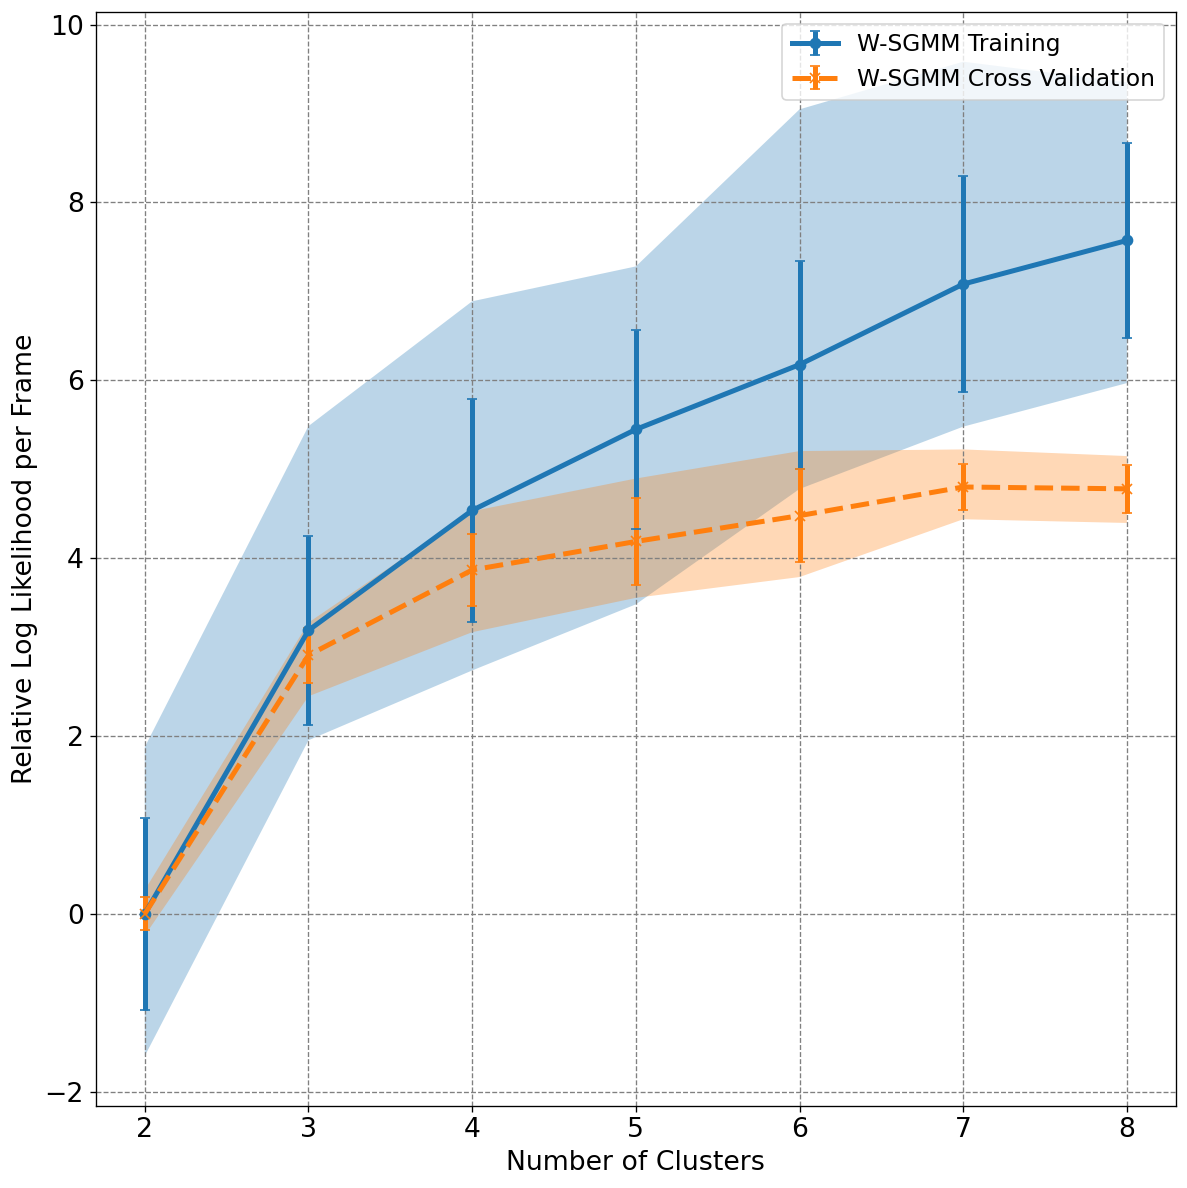

In [13]:
# create figure
plt.figure(figsize=(10,10), dpi= 120, facecolor='w', edgecolor='k')
# weighted SGMM
weighted_train_mean = np.mean(weighted_train_log_lik,axis=1)
#weighted_train_mean_min = np.amin(weighted_train_mean)
#weighted_train_mean -= weighted_train_mean_min
#weighted_train_log_lik -= weighted_train_mean_min
weighted_train_std = np.std(weighted_train_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_train_mean,weighted_train_std,fmt='-o',lw=3,capsize=3,label="W-SGMM Training")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_train_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
weighted_predict_mean = np.mean(weighted_predict_log_lik,axis=1)
#weighted_predict_mean_min = np.amin(weighted_predict_mean)
#weighted_predict_mean -= weighted_predict_mean_min
#weighted_predict_log_lik -= weighted_predict_mean_min
weighted_predict_std = np.std(weighted_predict_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_predict_mean,weighted_predict_std,fmt='--x',lw=3,capsize=3,label="W-SGMM Cross Validation")
lower, upper = pyemma.util.statistics.confidence_interval((weighted_predict_log_lik).T.tolist(), conf=0.9)
plt.fill_between(cluster_array, lower, upper, alpha=0.3)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame",fontsize=16)
plt.xlabel("Number of Clusters",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=14)
plt.tight_layout()

## Cluster again based on nClusters chosen above

In [41]:
n_clusters = 3
objs = []
log_likes = []
for i in range(5):
    wsgmm = gmm_shapes.ShapeGMM(n_clusters,kabsch_thresh=1e-1,init_cluster_method='random',init_iter=5)
    wsgmm.fit_weighted(trajData[1::5])
    print(i+1, wsgmm.log_likelihood/wsgmm.n_frames)
    objs.append(wsgmm)
    log_likes.append(wsgmm.log_likelihood)
# select obj with max log likelihood per frame
wsgmm = objs[np.argmax(log_likes)]

1 10.741217513680391
2 11.180939501402865
3 10.741217489097775
4 11.180939440407098
5 11.264455029242068


## Predict on entire of trajectory

In [42]:
clusters, aligned_traj, log_likelihood = wsgmm.predict_weighted(trajData)

# Make some plots on 2D RMSD space

In [40]:
# create RMSD data of selections
trajRMSD_hx = np.empty(coord.trajectory.n_frames-1,dtype=float)
trajRMSD_3_10 = np.empty(coord.trajectory.n_frames-1,dtype=float)
hx = coord.select_atoms("name CA and resid 2:9")
h_3_10 = coord.select_atoms("name CA and resid 11:15")
# make first frame the reference (arbitrary but there you have it)
hx_ref = np.copy(hx.positions)
h_3_10_ref = np.copy(h_3_10.positions)
for ts in coord.trajectory[1::]:
    trajRMSD_hx[ts.frame-1] = rmsd(hx.positions,hx_ref,superposition=True)
    trajRMSD_3_10[ts.frame-1] = rmsd(h_3_10.positions,h_3_10_ref,superposition=True)

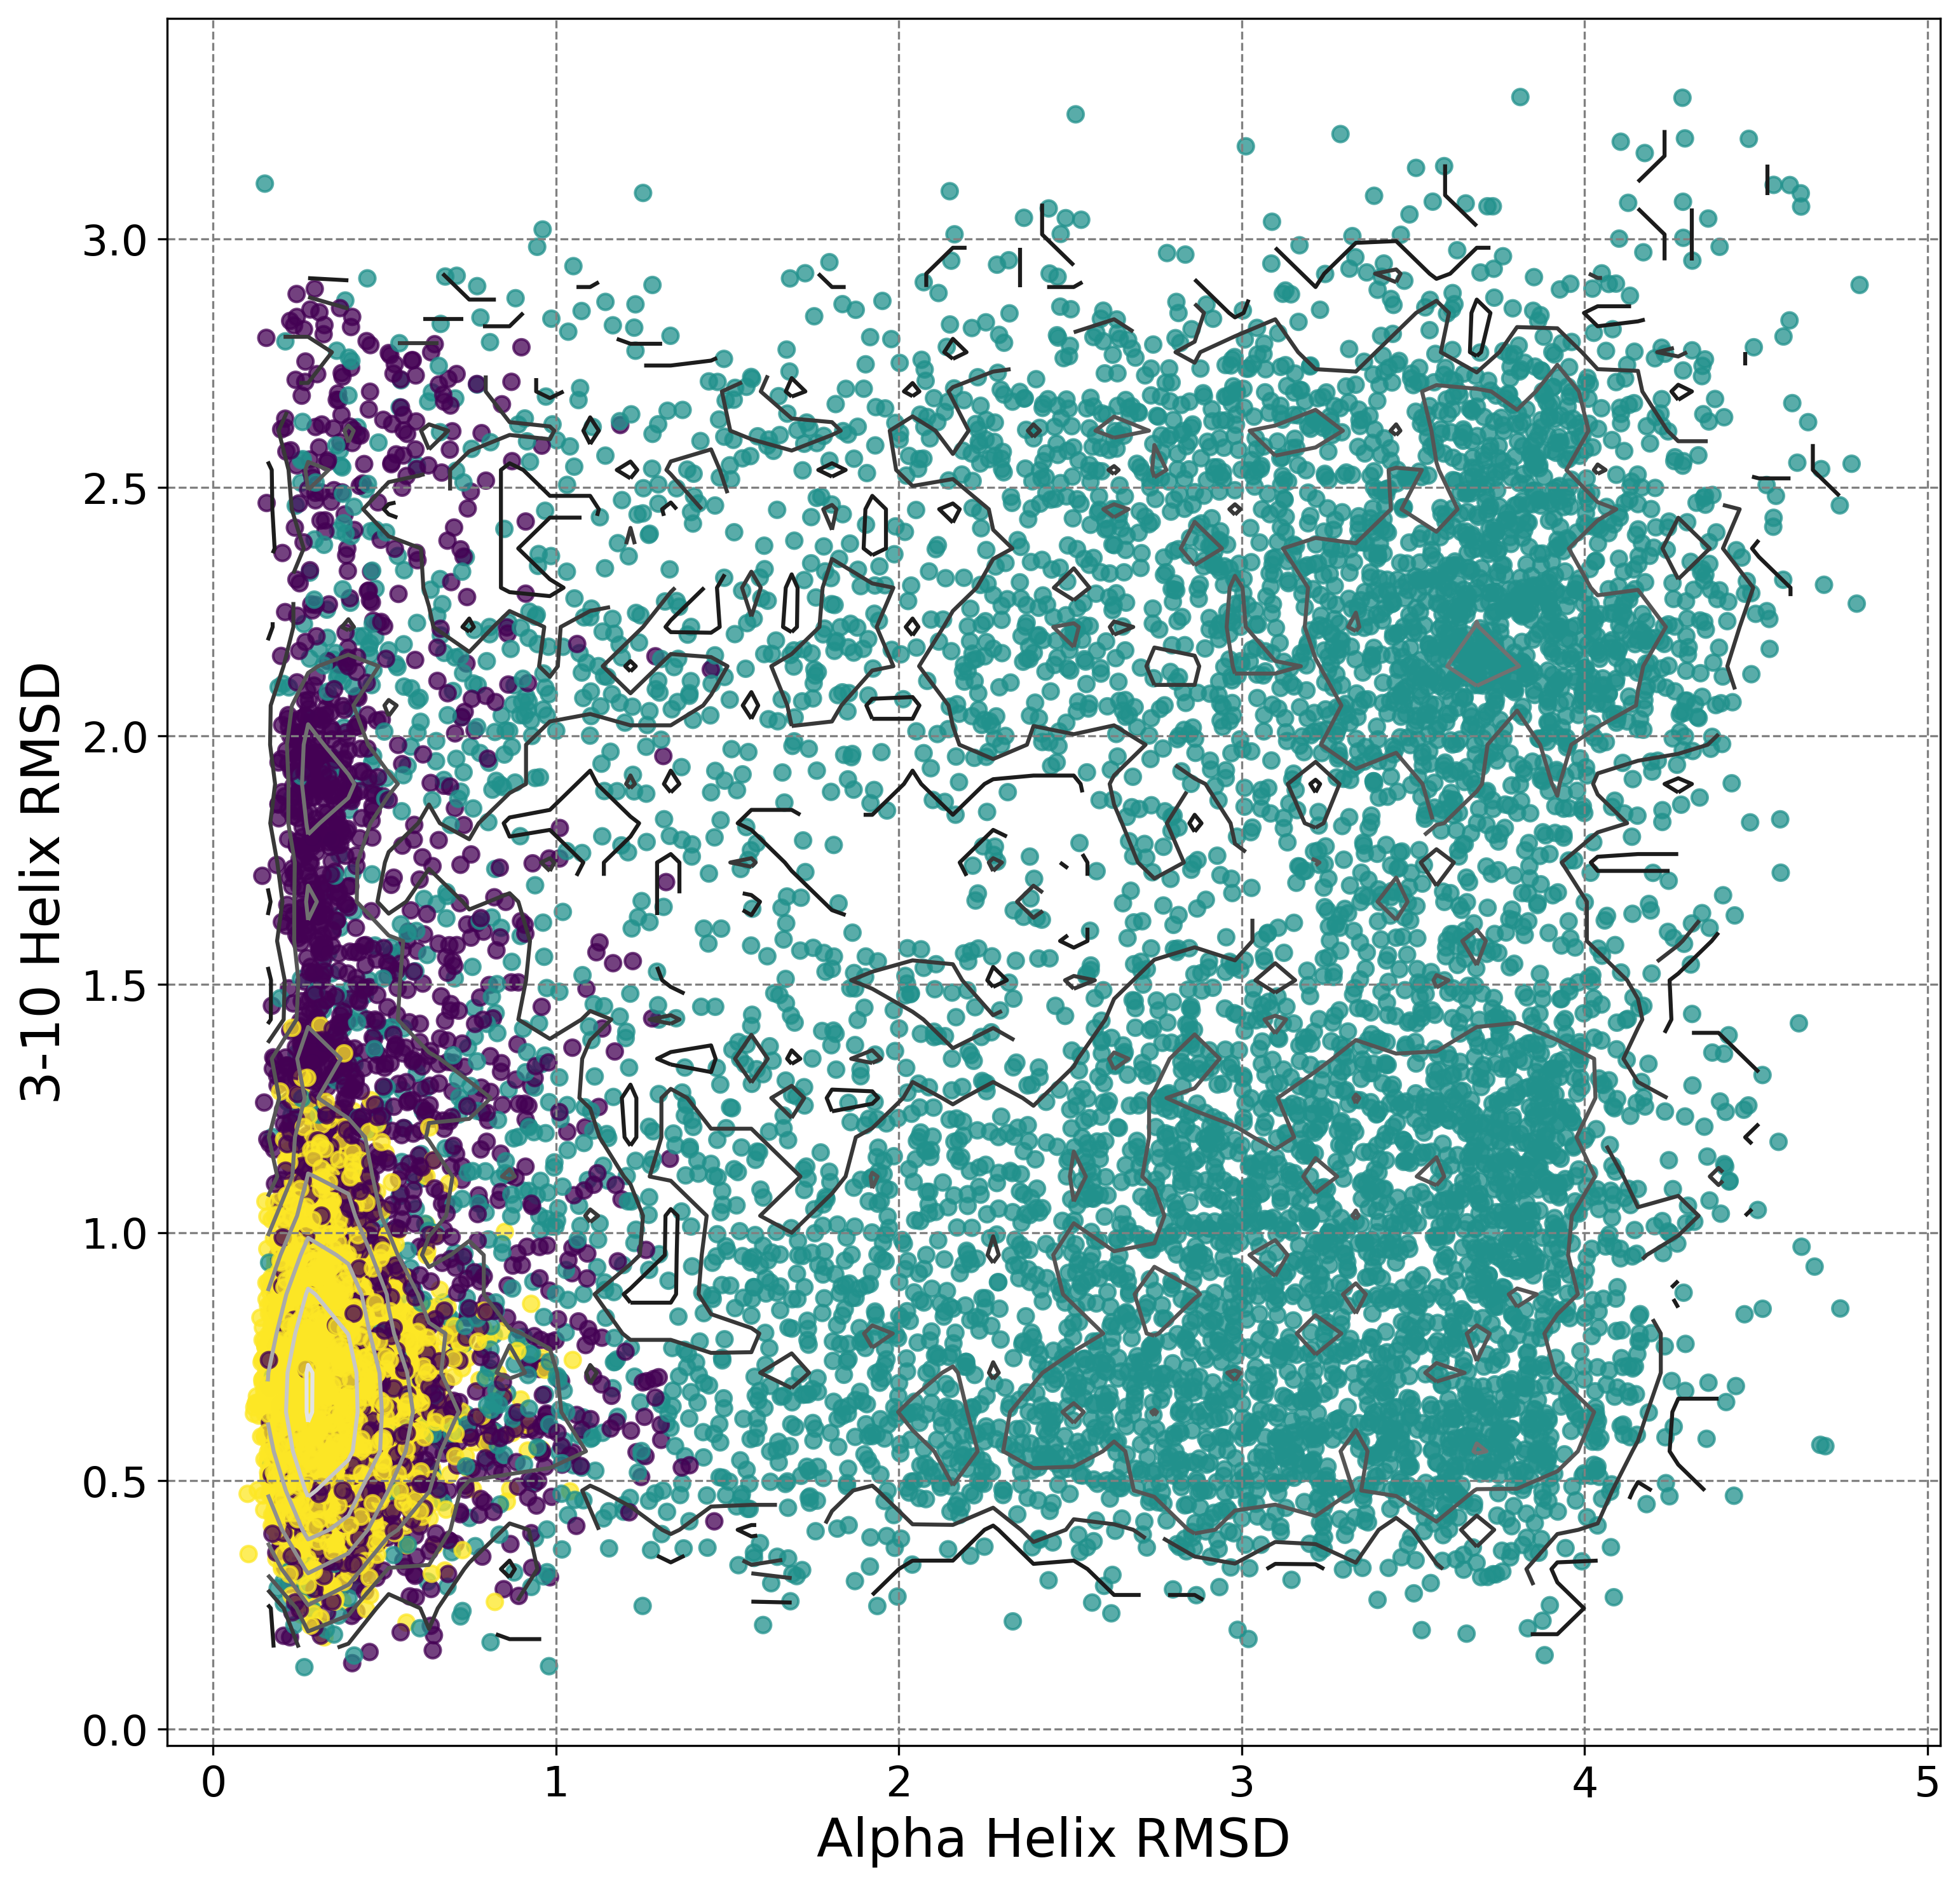

In [44]:
# plot data on LDA 1 and LDA 2 with points colored by cluster number
import matplotlib.cm as cm
plt.figure(figsize=(12, 12),dpi=300)
plt.xlabel("Alpha Helix RMSD",fontsize=20)
plt.ylabel("3-10 Helix RMSD",fontsize=20)
x = trajRMSD_hx
y = trajRMSD_3_10
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
plt.contour(xx,yy,H,cmap='binary')
plt.tick_params(axis='both',labelsize=16)
plt.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
plt.scatter(trajRMSD_hx,trajRMSD_3_10,c=clusters[1:],alpha=0.75)

# Align Trajectory in a Variety of Ways

In [45]:
from shapeGMM import _traj_tools as traj_tools

In [49]:
# start with a global alignment of all frames using covariance weighted alignment (iterative)
# NOTE: This will take ~30 seconds
global_aligned_traj = traj_tools.traj_iterative_average_precision_weighted_kabsch(trajData)[0]

In [52]:
# Align to cluster 1 (non-iterative)
# NOTE: I have no idea which cluster is cluster 1
cluster_1_aligned_traj = traj_tools.traj_align_weighted_kabsch(trajData,wsgmm.centers[0],wsgmm.precisions[0])

In [55]:
# Align to cluster 2 (non-iterative)
# NOTE: I have no idea which cluster is cluster 2
cluster_2_aligned_traj = traj_tools.traj_align_weighted_kabsch(trajData,wsgmm.centers[1],wsgmm.precisions[1])

In [56]:
# Align to cluster 3 (non-iterative)
# NOTE: I have no idea which cluster is cluster 3
cluster_3_aligned_traj = traj_tools.traj_align_weighted_kabsch(trajData,wsgmm.centers[2],wsgmm.precisions[2])

# Linear Discriminant Analysis

(-10.0, 3.0)

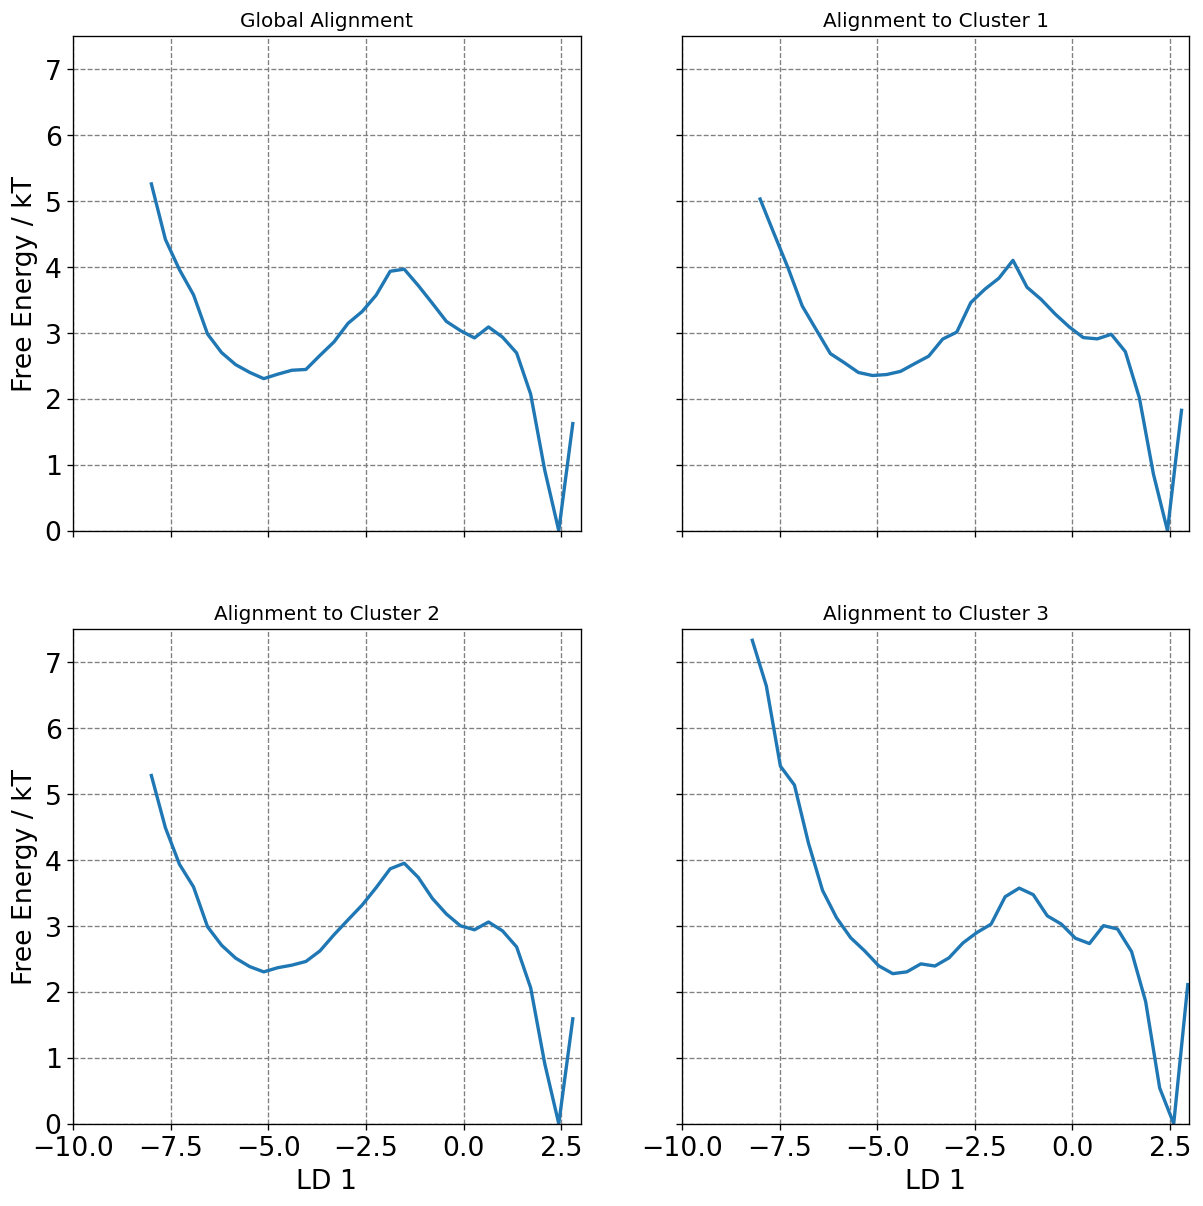

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi=120,sharey=True,sharex=True)
# 00
axes[0,0].set_title("Global Alignment")
axes[0,0].set_ylabel("Free Energy / kT",fontsize=16)
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_sgmm3 = lda.fit_transform(global_aligned_traj.reshape(coord.trajectory.n_frames, CAatomSel.n_atoms*3), clusters)
fe = -np.log(np.histogram(y_pred_sgmm3[:,0],range=(-8,10),bins=50)[0])
axes[0,0].tick_params(axis='both',labelsize=16)
axes[0,0].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
axes[0,0].plot(np.arange(-8,10,0.36),fe-np.amin(fe),lw=2)
axes[0,0].set_ylim(0,7.5)
axes[0,0].set_xlim(-10,3)
# 01
axes[0,1].set_title("Alignment to Cluster 1")
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_gmm3 = lda.fit_transform(cluster_1_aligned_traj.reshape(coord.trajectory.n_frames, CAatomSel.n_atoms*3), clusters)
fe = -np.log(np.histogram(y_pred_gmm3[:,0],range=(-8,10),bins=50)[0])
axes[0,1].tick_params(axis='both',labelsize=16)
axes[0,1].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
axes[0,1].plot(np.arange(-8,10,0.36),fe-np.amin(fe),lw=2)
axes[0,1].set_ylim(0,7.5)
axes[0,1].set_xlim(-10,3)
# 10
axes[1,0].set_title("Alignment to Cluster 2")
axes[1,0].set_xlabel("LD 1",fontsize=16)
axes[1,0].set_ylabel("Free Energy / kT",fontsize=16)
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_gmm3 = lda.fit_transform(cluster_2_aligned_traj.reshape(coord.trajectory.n_frames, CAatomSel.n_atoms*3), clusters)
fe = -np.log(np.histogram(y_pred_gmm3[:,0],range=(-8,10),bins=50)[0])
axes[1,0].tick_params(axis='both',labelsize=16)
axes[1,0].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
axes[1,0].plot(np.arange(-8,10,0.36),fe-np.amin(fe),lw=2)
axes[1,0].set_ylim(0,7.5)
axes[1,0].set_xlim(-10,3)
# 11
axes[1,1].set_title("Alignment to Cluster 3")
axes[1,1].set_xlabel("LD 1",fontsize=16)
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred_gmm3 = lda.fit_transform(cluster_3_aligned_traj.reshape(coord.trajectory.n_frames, CAatomSel.n_atoms*3), clusters)
fe = -np.log(np.histogram(y_pred_gmm3[:,0],range=(-8,10),bins=50)[0])   # this one needs to be flipped
axes[1,1].tick_params(axis='both',labelsize=16)
axes[1,1].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
axes[1,1].plot(-np.arange(-8,10,0.36),fe-np.amin(fe),lw=2)
axes[1,1].set_ylim(0,7.5)
axes[1,1].set_xlim(-10,3)

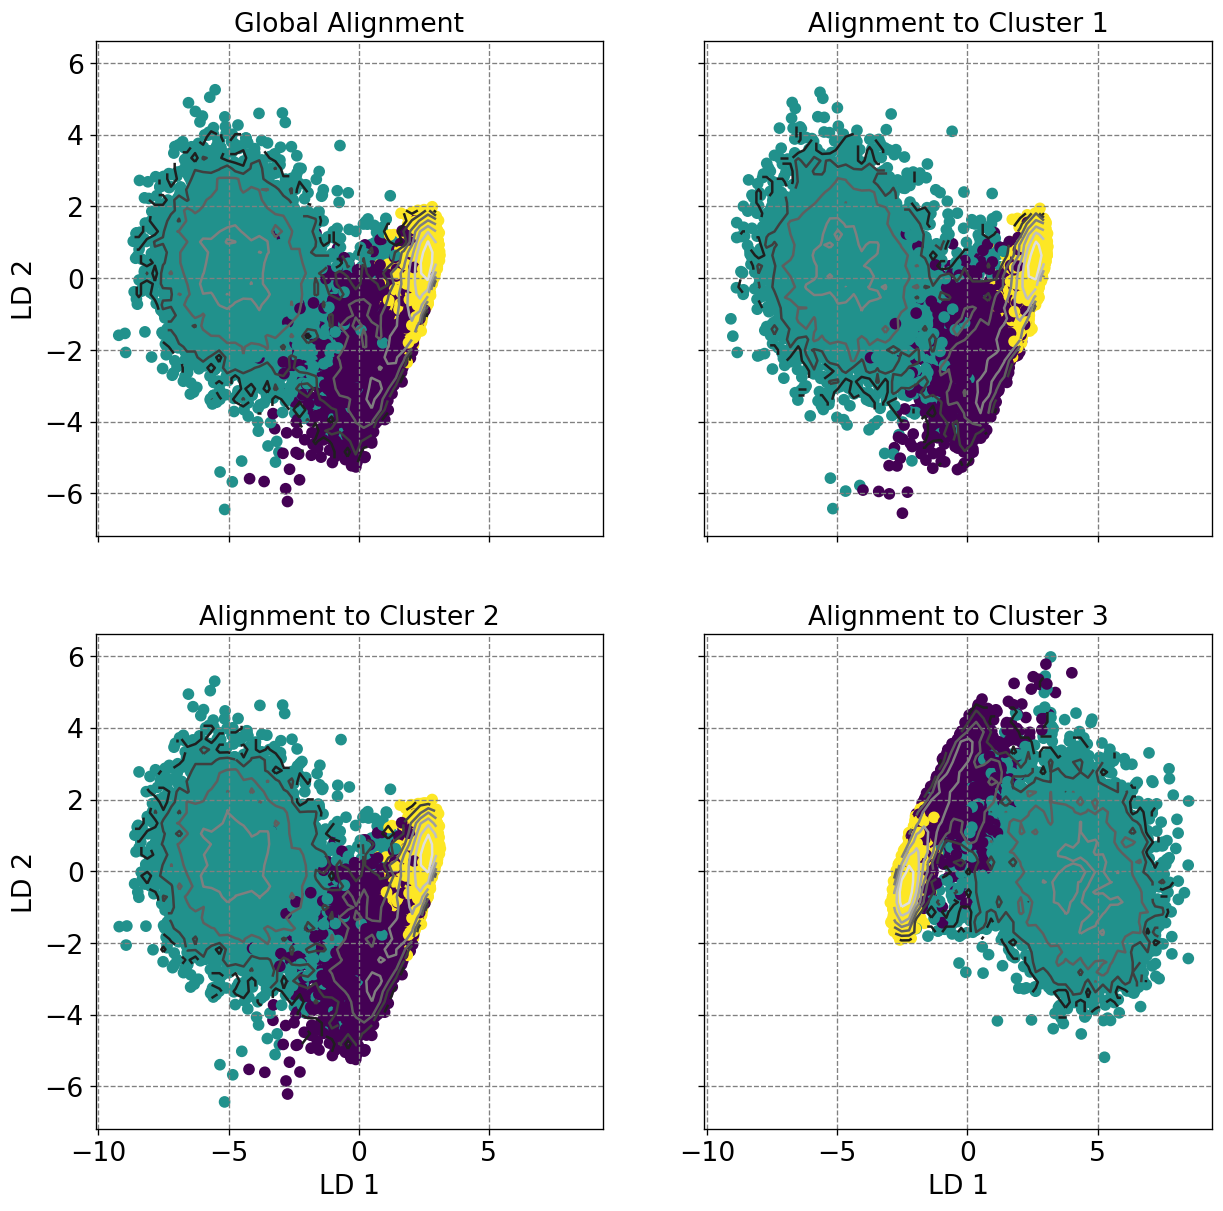

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi=120,sharey=True,sharex=True)
# 00
axes[0,0].set_title("Global Alignment",fontsize=16)
axes[0,0].set_ylabel("LD 2",fontsize=16)
axes[0,0].tick_params(axis='both',labelsize=16)
axes[0,0].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit_transform(global_aligned_traj.reshape(coord.trajectory.n_frames, CAatomSel.n_atoms*3), clusters)
x = y_pred[:,0]
y = y_pred[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
axes[0,0].contour(xx,yy,H,cmap='binary')
axes[0,0].scatter(y_pred[:,0],y_pred[:,1],c=clusters)
#01
axes[0,1].set_title("Alignment to Cluster 1",fontsize=16)
axes[0,1].tick_params(axis='both',labelsize=16)
axes[0,1].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit_transform(cluster_1_aligned_traj.reshape(coord.trajectory.n_frames, CAatomSel.n_atoms*3), clusters)
x = y_pred[:,0]
y = y_pred[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
axes[0,1].contour(xx,yy,H,cmap='binary')
axes[0,1].scatter(y_pred[:,0],y_pred[:,1],c=clusters)
#10
axes[1,0].set_title("Alignment to Cluster 2",fontsize=16)
axes[1,0].set_ylabel("LD 2",fontsize=16)
axes[1,0].set_xlabel("LD 1",fontsize=16)
axes[1,0].tick_params(axis='both',labelsize=16)
axes[1,0].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit_transform(cluster_2_aligned_traj.reshape(coord.trajectory.n_frames, CAatomSel.n_atoms*3), clusters)
x = y_pred[:,0]
y = y_pred[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
axes[1,0].contour(xx,yy,H,cmap='binary')
axes[1,0].scatter(y_pred[:,0],y_pred[:,1],c=clusters)
# 11
axes[1,1].set_title("Alignment to Cluster 3",fontsize=16)
axes[1,1].set_xlabel("LD 1",fontsize=16)
axes[1,1].tick_params(axis='both',labelsize=16)
axes[1,1].grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit_transform(cluster_3_aligned_traj.reshape(coord.trajectory.n_frames, CAatomSel.n_atoms*3), clusters)
x = y_pred[:,0]
y = y_pred[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
axes[1,1].contour(xx,yy,H,cmap='binary')
axes[1,1].scatter(y_pred[:,0],y_pred[:,1],c=clusters)